In [1]:
# Initialization
%load_ext autoreload
%autoreload 2
import sys
import os
import pathlib

# To be able to reference packages/modules in this repository, this
# relative path must be added to the python path. Your notebook may be 
# in a different folder, so modify this variable to point to the src 
# folder.
proj_notebooks_root = pathlib.Path().absolute()
proj_root_path = proj_notebooks_root.parent
data_path = proj_root_path / "data"

if proj_root_path not in sys.path:
    sys.path.insert(0, proj_root_path.as_posix())
    print("Updated Python Path")

print(f"Project Root Path: {proj_root_path}")
print(f"Project Source Root Path: {proj_notebooks_root}")
print(f"Project Data Path: {data_path}")

Updated Python Path
Project Root Path: /home/default/workspace/roadsegm
Project Source Root Path: /home/default/workspace/roadsegm/ActiveLearning
Project Data Path: /home/default/workspace/roadsegm/data


In [2]:
# !pip install --user kaggle

In [3]:
# !mkdir /home/default/.kaggle/
# !touch /home/default/.kaggle/kaggle.json

# api_token = {"username":"username","key":"key"}

# import json

# with open('/home/default/.kaggle/kaggle.json', 'w') as file:
#     json.dump(api_token, file)

# !chmod 600 ~/.kaggle/kaggle.json


# !sudo apt-get update
# !sudo apt-get install unzip


In [4]:
base_dir = data_path / 'deepcrack'
if not base_dir.exists():
    ! wget -O {data_path / 'DeepCrack.zip'} https://github.com/yhlleo/DeepCrack/raw/master/dataset/DeepCrack.zip 
#     ! kaggle datasets download -p {data_path.as_posix()} -d lakshaymiddha/crack-segmentation-dataset
    ! unzip -q {data_path / 'DeepCrack.zip'} -d {data_path}
    ! rm {data_path / 'DeepCrack.zip'} 
else:
    print("Found dataset at ", base_dir.as_posix())


Found dataset at  /home/default/workspace/roadsegm/data/deepcrack


In [5]:
f = [y for y in (base_dir).glob('*')] 
print(f"Found {len(f)} dirs in {base_dir}")

counts = {}

for i in f:
    files = [y for y in i.glob('*')] 
    num = len(files)
    counts[i.stem] = num
print(counts)
files[:5]

Found 5 dirs in /home/default/workspace/roadsegm/data/deepcrack
{'train_lab': 300, 'README': 0, 'test_lab': 237, 'train_img': 300, 'test_img': 237}


[PosixPath('/home/default/workspace/roadsegm/data/deepcrack/test_img/11249-1.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/deepcrack/test_img/IMG_6522-3.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/deepcrack/test_img/11271-3.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/deepcrack/test_img/IMG_6528-3.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/deepcrack/test_img/11142-2.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/deepcrack/test_img/IMG_6542-4.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/deepcrack/test_img/11215-7.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/deepcrack/test_img/IMG_6533-3.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/deepcrack/test_img/11267-2.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/deepcrack/test_img/11236-6.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/deepcrack/test_img/11267-1.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/deepcrack/test

In [6]:
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import cv2
from torch.cuda.amp import GradScaler, autocast
import torchvision
from tqdm import tqdm
from torchinfo import summary
import time

from sklearn import metrics

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.1.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Using device: cuda



In [7]:
X_dir = base_dir/'train_img'
y_dir = base_dir/'train_lab'

X_files = [y for y in X_dir.glob('*')] 

for i in X_files:
    assert((y_dir / (i.stem + ".png")).exists())

all_files = [(x, (y_dir / (x.stem + ".png"))) for x in X_dir.glob('*')] 
for i in range(10):
    print(all_files[i][0].name)


IMG25-6.jpg
7Q3A9064-4.jpg
11136.jpg
11182-2.jpg
11192.jpg
IMG11-5.jpg
11140-1.jpg
7Q3A9060-12.jpg
11133.jpg
11148.jpg


In [8]:
class CracksDataset(torch.utils.data.Dataset):
    def __init__(self, files,image_transforms=None, both_transforms=None):
        self.files = files
        
        self.image_transforms = image_transforms
        self.both_transforms = both_transforms
        self.segment_transforms = transforms.Compose([
            transforms.ToTensor()
        ])
    
    def __len__(self):
        return len(self.files)
    

    def __getitem__(self, idx):
        imagePath, segmentPath = self.files[idx]

        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = Image.open(imagePath).convert("RGB")
        
        mask = cv2.imread(segmentPath)
#         segment = Image.open(segmentPath).convert("L")
#         segment = self.segment_transforms(segment)
#         print(segment)
        
            
        if self.image_transforms is not None:
            image = self.image_transforms(image)
            
        if self.both_transforms is not None:
            transformed = transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        
        return image, segment.type(torch.int64) 


In [9]:
class FocalLoss(torch.nn.Module):
    """
    References:
        Author: clcarwin
        Site https://github.com/clcarwin/focal_loss_pytorch/blob/master/focalloss.py
    """

    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)):
            self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list):
            self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)  # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))  # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = torch.nn.functional.log_softmax(input, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = logpt.data.exp()

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            select = (target != 0).type(torch.LongTensor).to(self.alpha.device)
            at = self.alpha.gather(0, select.data.view(-1))
            logpt = logpt * at

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [10]:
import albumentations as A
data_transforms = {
    'both': A.Compose([
        A.RandomCrop(width=256, height=256),
        A.RandomRotate90(p=0.3),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.OneOf([
            A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
        ], p=0.8)]),
        A.RandomBrightnessContrast(p=0.2),
        A.ToTensorV2()
]),
    'images': transforms.Compose([
#         transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

all_files = all_files
random.shuffle(all_files)

train_count = len(all_files)*8//10

train_dataset = CracksDataset(all_files[:train_count],
                              image_transforms=data_transforms['images'], 
                              both_transforms=data_transforms['both'])

val_dataset = CracksDataset(all_files[train_count:],
                              image_transforms=data_transforms['images'], 
                              both_transforms=data_transforms['both'])

print(f"Created train_dataset with {len(train_dataset)} datapoints.")
print(f"Created val_dataset with {len(val_dataset)} datapoints.")


batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         prefetch_factor=2,
                                         pin_memory=True,
                                         num_workers=8)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=8)

Created train_dataset with 240 datapoints.
Created val_dataset with 60 datapoints.


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


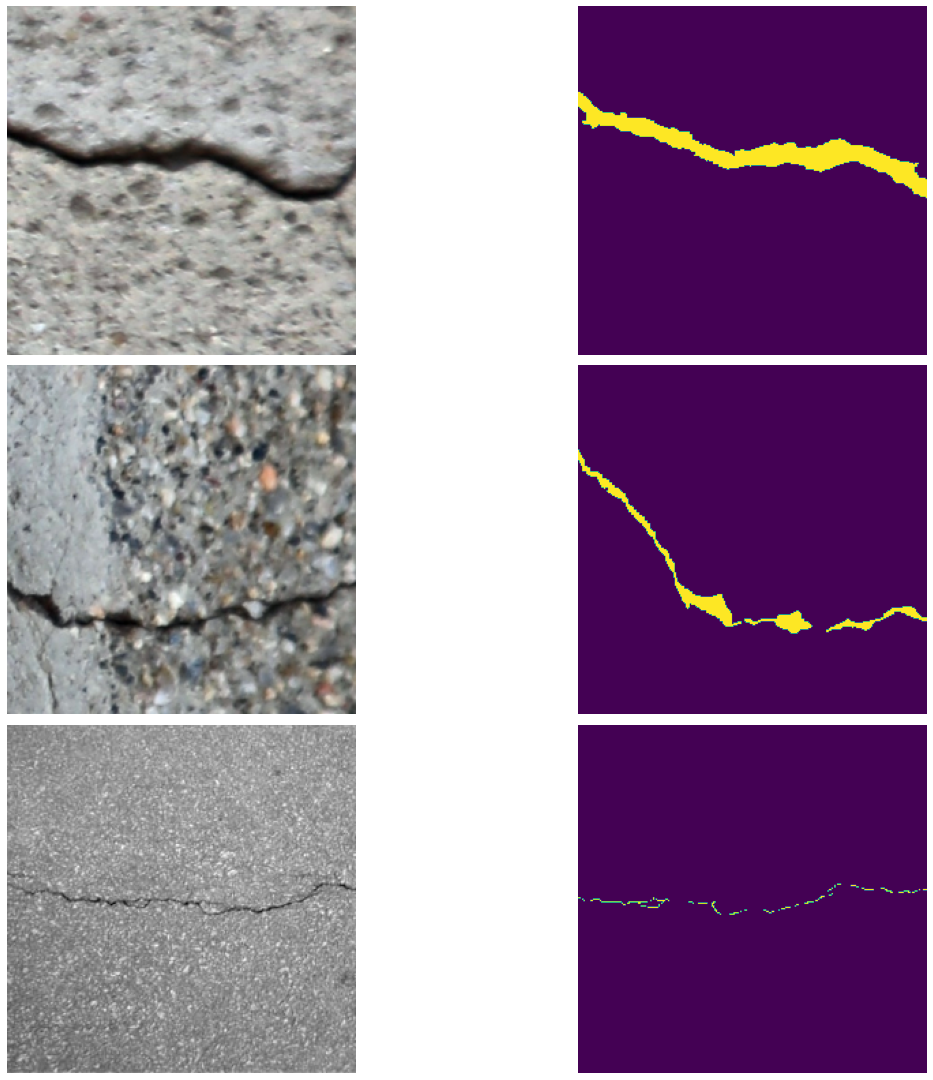

In [11]:
batch = next(iter(train_dataloader))
tensors = batch[0]
segments = batch[1]

# tensors, metadata
y = int(len(tensors)/2+0.5); x = 2
fig = plt.figure(figsize=(8*x, 5*y))

for i in range(min(len(tensors)//2, 3)):
#     print(y*100 + x*10 + i)
    ax = fig.add_subplot(y , x , (i*2) + 1)
    image = tensors[i].permute(1,2,0).cpu().numpy()
    print(image.shape)
    image = (image - [image[:,:,0].min(), image[:,:,1].min(), image[:,:,2].min()])
    image = image/([image[:,:,0].max(), image[:,:,1].max(), image[:,:,2].max()])
    ax.set_axis_off()
    ax.imshow(image)
    plt.tight_layout()
    
    ax = fig.add_subplot(y , x , (i*2) + 2)
    image = segments[i].permute(1,2,0).cpu().numpy()
    image = np.squeeze(image)
#     image = np.atleast_3d(image)
    ax.set_axis_off()
    ax.imshow(image)
    plt.tight_layout()
    


In [26]:
def get_eval_metrics(pred, gold, threshold = 0.5):
#     print(pred.shape)
#     print(gold.shape)
    pr_auc = 0
    for i in range(pred.shape[0]):
        pr_auc += metrics.average_precision_score(gold[i].cpu().numpy().flatten(),
                                                  pred[i].cpu().numpy().flatten())
    pred = (pred > threshold).long()
    gold = gold.long()
    hits = torch.sum(torch.mul(pred, gold)).item() #element-wise multiplication
    shots = torch.sum(pred).item()
    targets = torch.sum(gold).item()
#     print(hits, shots, targets)
    return hits, shots, targets, pr_auc

def train_loop(dataloader, model, loss_fn, optimizer, history, lr_sched = None):
    size = len(dataloader.dataset)
    model.train()
    loss_sum = 0
    bar_format = "{l_bar}{bar} {elapsed}<{remaining} {rate_fmt}{postfix}"
    
    with tqdm(dataloader, unit="batch", bar_format=bar_format) as tepoch:
        for X, y in tepoch:
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()

            # Runs the forward pass with autocasting.
            with autocast():
                output = model(X)
                loss = loss_fn(output, y)

            # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
            # Backward passes under autocast are not recommended.
            # Backward ops run in the same dtype autocast chose for corresponding forward ops.
            scaler.scale(loss).backward()

            # scaler.step() first unscales the gradients of the optimizer's assigned params.
            # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
            # otherwise, optimizer.step() is skipped.
            scaler.step(optimizer)

            # Updates the scale for next iteration.
            scaler.update()
            
            loss_sum += loss.item()

            if(lr_sched is not None):
                lr_sched.step()

            loss = loss.item()
            tepoch.set_postfix(
                loss=round(loss, 4), 
                lr=round(lr_sched.get_last_lr()[0], 4)
            )
        history['train_lr'].append(lr_sched.get_last_lr()[0])
        history['train_loss'].append(loss_sum/len(dataloader))
    
    
def test_loop(dataloader, model, loss_fn, history):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss = 0
    total_hits = 0
    total_shots = 0
    total_targets = 0
    total_auc = 0
    with torch.no_grad():
        for X, y in tqdm(dataloader, desc="Testing", unit="batches"):
            X = X.to(device)
            y = y.to(device)
#             print(y.shape)
            
            output = model(X)
            
            loss += loss_fn(output, y).item()
            hits, shots, targets, auc = get_eval_metrics(output[1], y)
            total_hits += hits
            total_shots += shots
            total_targets += targets
            total_auc += auc

    loss /= num_batches
    history['test_loss'].append(loss)
    history['test_hits'].append(total_hits)
    history['test_shots'].append(total_shots)
    history['test_targets'].append(total_targets)
    history['test_auc'].append(total_auc/len(dataloader.dataset))
    
    if total_shots == 0:
        precision = 0
        recall = 0
        f1score = 0
    else:
        precision = total_hits/total_shots
        recall = total_hits/total_targets
        f1score = (2 * precision * recall)/(precision + recall)
        

    history['test_precision'].append(precision)
    history['test_recall'].append(recall)
    history['test_f1score'].append(f1score)
    

In [27]:
class SegModel(torch.nn.Module):

    def __init__(self, numclasses):
        super(SegModel, self).__init__()

        self.fcn = torchvision.models.segmentation.fcn_resnet50(
            weights=None, 
            num_classes = numclasses, 
            aux_loss = False,
            weights_backbone=torchvision.models.ResNet50_Weights.DEFAULT)
#         self.softmax = torch.nn.Softmax(0)

    def forward(self, x):
        x = self.fcn(x)['out']
#         x = self.softmax(x)
        return x

In [28]:
model = SegModel(2)
model.to(device)

epochs = 10

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.00001, momentum=0.9)

lr_sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                       max_lr=0.01, 
                       steps_per_epoch=len(train_dataloader), 
                       epochs=epochs)

# loss_fn = torch.nn.BCEWithLogitsLoss()
loss_fn = FocalLoss(gamma=2, alpha=0.25)


In [29]:
# Creates a GradScaler once at the beginning of training.

scaler = GradScaler()

history = {
    'train_lr':[],
    'train_loss':[],
    'test_loss':[],
    'test_hits':[],
    'test_shots':[],
    'test_targets':[],
    'test_precision': [],
    'test_recall': [],
    'test_f1score': [],
    'test_auc': []
}

begin = time.time()
  
for epoch in range(epochs):
    print()
    print(f'Epoch {epoch+1}')
    print("-------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, history, lr_sched)
    test_loop(val_dataloader, model, loss_fn, history)
    print(f"Training Loss: {history['train_loss'][-1]:.5}\tTesting Loss: {history['test_loss'][-1]:.5}")

end = time.time()


# watch -d -n 0.5 nvidia-smi
# Taking ~ 3 mins per epoch to train


Epoch 1
-------------


100%|██████████ 00:08<00:00  1.12batch/s, loss=0.0597, lr=0.003 
Testing: 100%|██████████| 3/3 [00:03<00:00,  1.28s/batches]


Training Loss: 0.084144	Testing Loss: 0.044256

Epoch 2
-------------


100%|██████████ 00:09<00:00  1.09batch/s, loss=0.0405, lr=0.0079
Testing: 100%|██████████| 3/3 [00:03<00:00,  1.22s/batches]


Training Loss: 0.034061	Testing Loss: 0.023249

Epoch 3
-------------


100%|██████████ 00:08<00:00  1.12batch/s, loss=0.0214, lr=0.01  
Testing: 100%|██████████| 3/3 [00:03<00:00,  1.18s/batches]


Training Loss: 0.026861	Testing Loss: 0.021551

Epoch 4
-------------


100%|██████████ 00:08<00:00  1.15batch/s, loss=0.019, lr=0.0094 
Testing: 100%|██████████| 3/3 [00:03<00:00,  1.26s/batches]


Training Loss: 0.021839	Testing Loss: 0.02095

Epoch 5
-------------


100%|██████████ 00:08<00:00  1.12batch/s, loss=0.0149, lr=0.0079
Testing: 100%|██████████| 3/3 [00:03<00:00,  1.22s/batches]


Training Loss: 0.017585	Testing Loss: 0.017721

Epoch 6
-------------


100%|██████████ 00:08<00:00  1.15batch/s, loss=0.0148, lr=0.0059
Testing: 100%|██████████| 3/3 [00:03<00:00,  1.33s/batches]


Training Loss: 0.016267	Testing Loss: 0.016845

Epoch 7
-------------


100%|██████████ 00:09<00:00  1.10batch/s, loss=0.0147, lr=0.0037
Testing: 100%|██████████| 3/3 [00:03<00:00,  1.19s/batches]


Training Loss: 0.016954	Testing Loss: 0.016411

Epoch 8
-------------


100%|██████████ 00:09<00:00  1.06batch/s, loss=0.0163, lr=0.0017
Testing: 100%|██████████| 3/3 [00:03<00:00,  1.19s/batches]


Training Loss: 0.016796	Testing Loss: 0.017444

Epoch 9
-------------


100%|██████████ 00:08<00:00  1.16batch/s, loss=0.0167, lr=0.0004
Testing: 100%|██████████| 3/3 [00:03<00:00,  1.31s/batches]


Training Loss: 0.016389	Testing Loss: 0.017728

Epoch 10
-------------


100%|██████████ 00:09<00:00  1.08batch/s, loss=0.0157, lr=0     
Testing: 100%|██████████| 3/3 [00:03<00:00,  1.22s/batches]

Training Loss: 0.016447	Testing Loss: 0.017062


In [30]:
# models_dir = proj_root_path / 'models'
# if not models_dir.exists():
#     models_dir.mkdir()

# # inf_model_name = "30-FCN-inference.pth"
# ent_model_name = "01-FCN-simple-2.pth"
# # torch.save(model.state_dict(), models_dir / inf_model_name)
# torch.save(model, models_dir / ent_model_name)

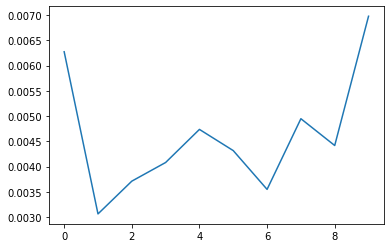

In [31]:

plt.plot(history['test_auc'], label='AP')

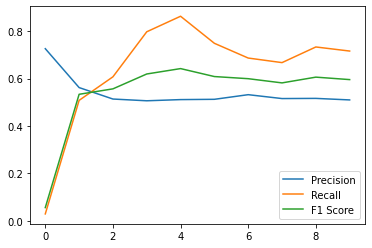

In [32]:
epochs_range = range(epochs)

plt.plot(history['test_precision'], label='Precision')
plt.plot(history['test_recall'], label='Recall')
plt.plot(history['test_f1score'], label='F1 Score')
plt.legend()

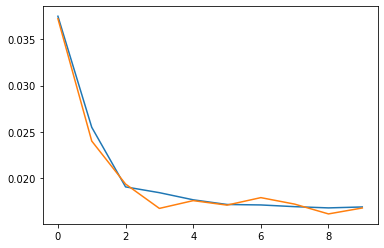

In [18]:

# plt.figure(figsize=(8,8))
# plt.subplots(1,2,1)
plt.plot(epochs_range, history['train_loss'], label='Training Loss')
plt.plot(epochs_range, history['test_loss'], label='Training Loss')

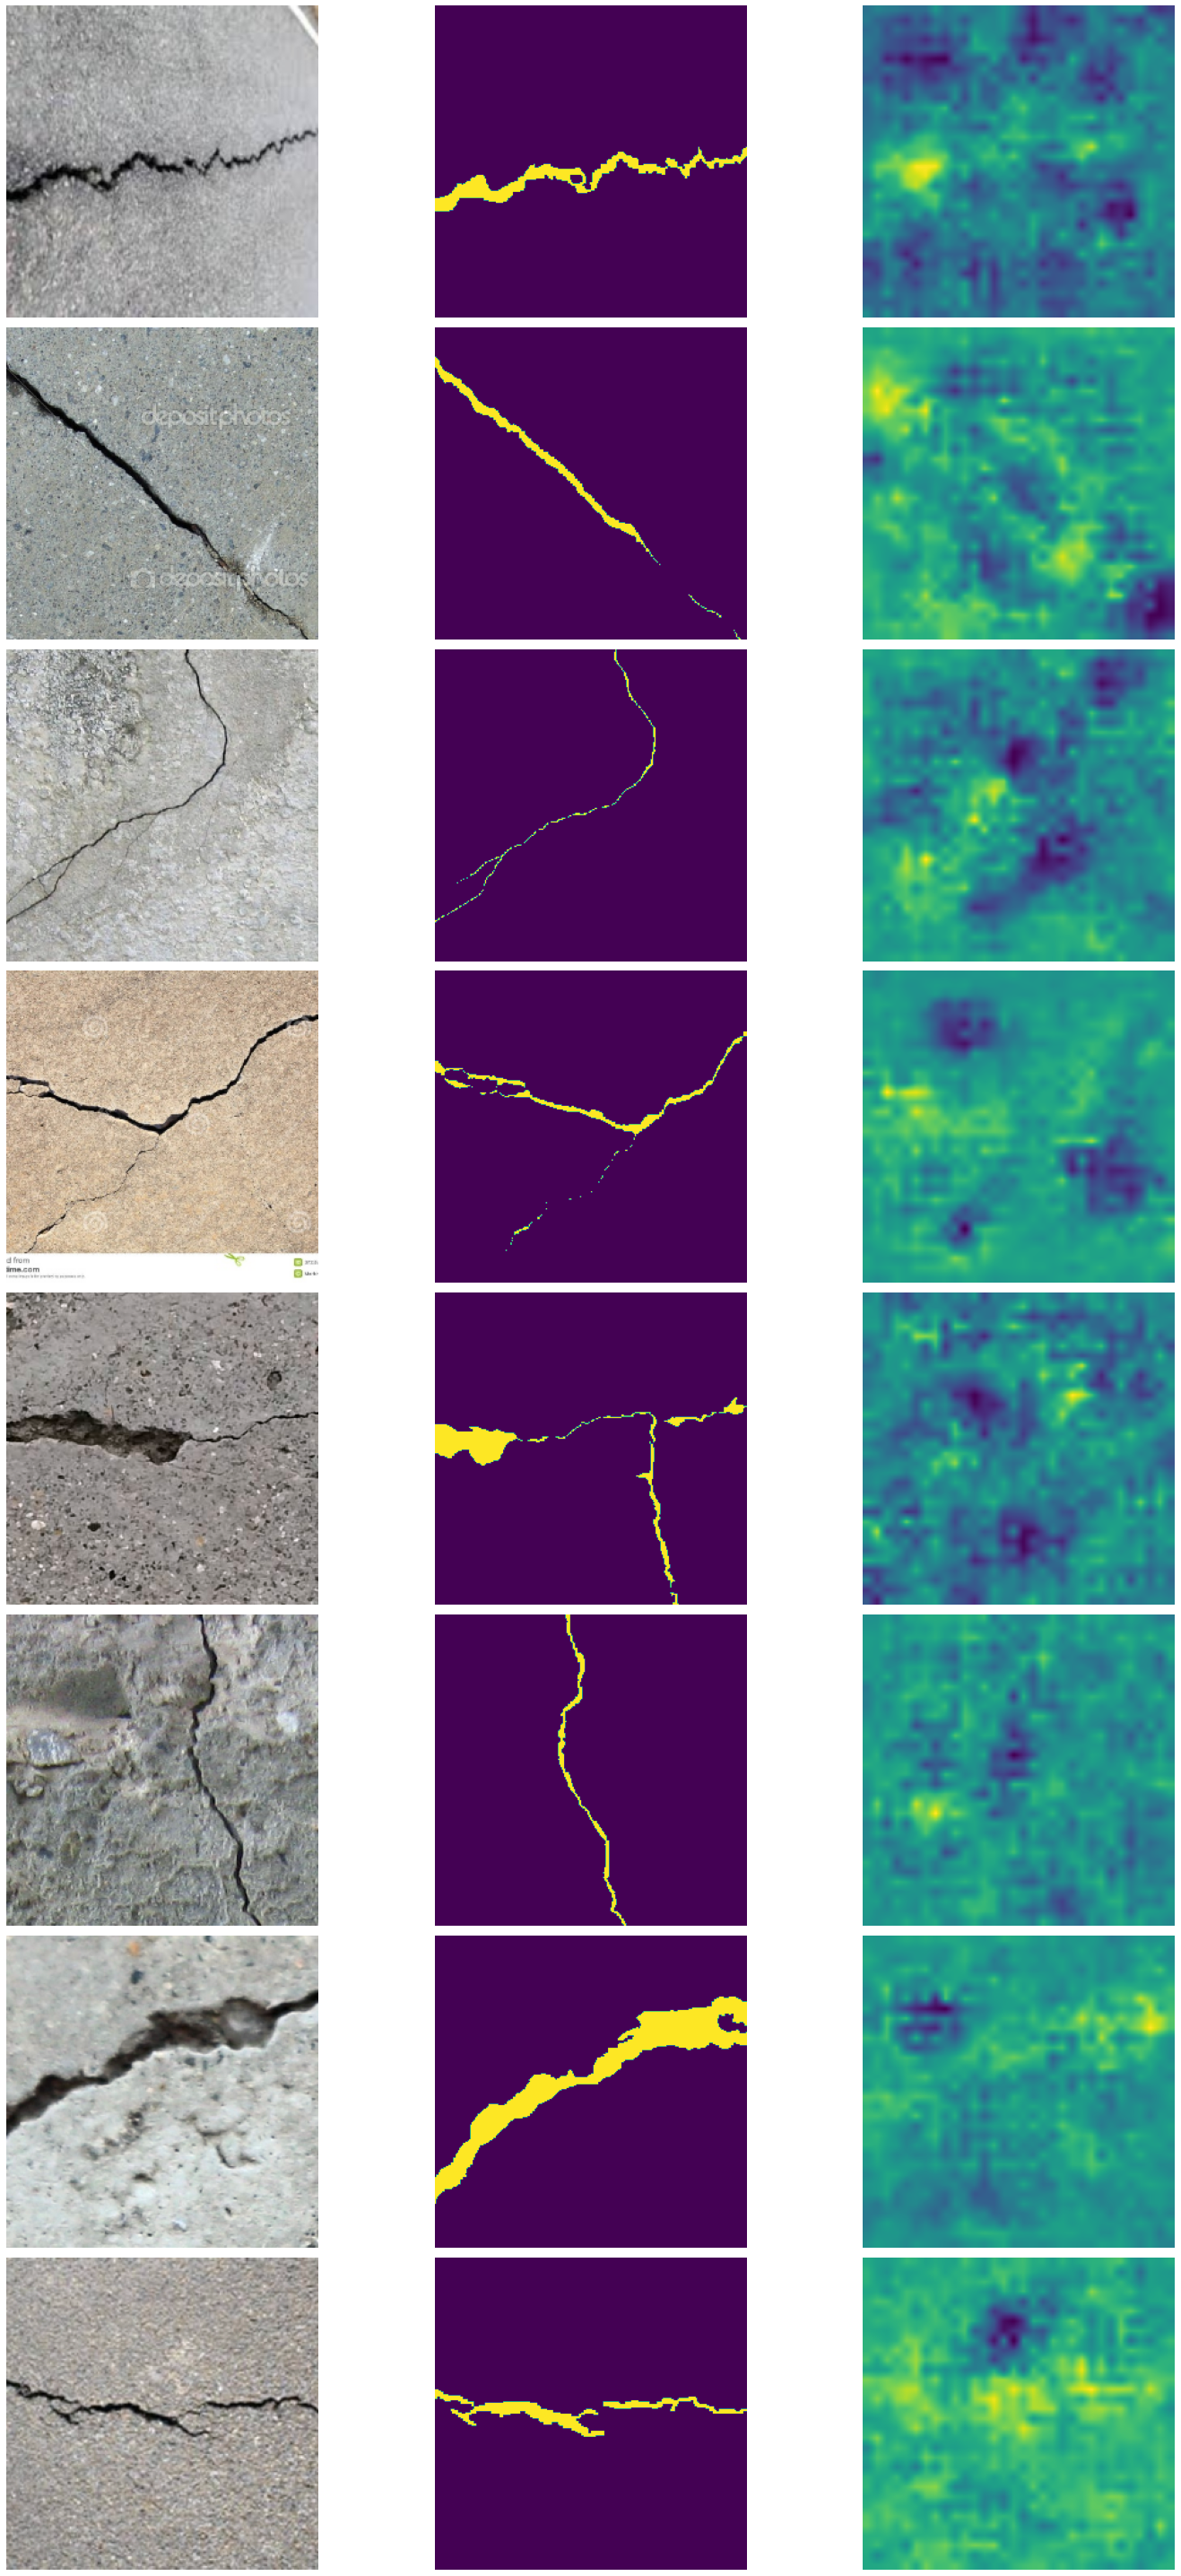

In [19]:
batch = next(iter(val_dataloader))
tensors = batch[0].to(device)
segments = batch[1]

with torch.no_grad():
    output = torch.sigmoid(model(tensors))

y = max(len(tensors)//3, 1)
x = 3
fig = plt.figure(figsize=(8*x, 5*y))

for i in range(y):
#     print(y*100 + x*10 + i)
    ax = fig.add_subplot(y , x , (i*3) + 1)
    image = tensors[i].permute(1,2,0).cpu().numpy()
    image = (image - [image[:,:,0].min(), image[:,:,1].min(), image[:,:,2].min()])
    image = image/([image[:,:,0].max(), image[:,:,1].max(), image[:,:,2].max()])
    ax.set_axis_off()
    ax.imshow(image)
    plt.tight_layout()
    
    ax = fig.add_subplot(y , x , (i*3) + 2)
    image = segments[i].cpu().numpy()
    image = np.squeeze(image)
    ax.set_axis_off()
    ax.imshow(image)
    plt.tight_layout()
    
    ax = fig.add_subplot(y , x , (i*3) + 3)
    image = output[i][1].cpu().numpy()
    image = np.squeeze(image)
    ax.set_axis_off()
    ax.imshow(image)
    plt.tight_layout()
    


(array([67954.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 63118.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

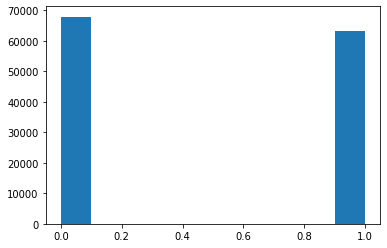

In [20]:
plt.hist((output[1].cpu().numpy().flatten() > 0.5).astype(int))

(array([64069.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1467.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

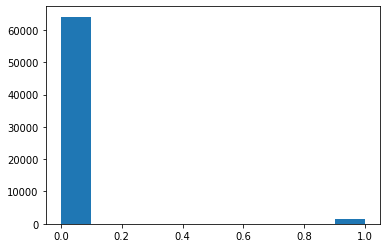

In [21]:
plt.hist(segments[1].cpu().numpy().flatten())

In [22]:
np.sum((output[1] > 0.5).cpu().numpy().astype(int) * segments[1].cpu().numpy().astype(int))

820

In [23]:
hits, shots, targets = get_eval_metrics(output[1].cpu(), segments[1])
precision = hits/shots
recall = hits/targets
f1score = (2 * precision * recall)/(precision + recall)

print("Hits:", hits)
print("Shots:", shots)
print("Targets:", targets)

print("Precision:",precision)
print("Recall:", recall)
print("F1 score:", f1score)

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [ ]:
from sklearn import metrics

In [ ]:
def get_eval_metrics(pred, gold, threshold = 0.5):
#     print(pred.shape)
#     print(gold.shape)
    pr_auc = 0
    for i in range(pred.shape[0]):
        pr_auc += metrics.average_precision_score(gold[i].cpu().numpy().flatten(),
                                                  pred[i].cpu().numpy().flatten())
    pred = (pred > threshold).long()
    gold = gold.long()
    hits = torch.sum(torch.mul(pred, gold)).item() #element-wise multiplication
    shots = torch.sum(pred).item()
    targets = torch.sum(gold).item()
#     print(hits, shots, targets)
    return hits, shots, targets, pr_auc

In [ ]:
output = torch.Tensor([1, 1, 1, 1, 0, 0, 0, 0, 0])
target = torch.Tensor([0, 1, 1, 1, 1, 1, 0, 0, 0])

hits, shots, targets, auc = get_eval_metrics(output, target)
precision = hits/shots
recall = hits/targets
f1score = (2 * precision * recall)/(precision + recall)

print("Hits:", hits)
print("Shots:", shots)
print("Targets:", targets)

print("Precision:",precision)
print("Recall:", recall)
print("F1 score:", f1score)
print(f"AUC: {auc}")

In [ ]:

history = {
    'train_lr':[],
    'train_loss':[],
    'test_loss':[],
    'test_hits':[],
    'test_shots':[],
    'test_targets':[],
    'test_precision': [],
    'test_recall': [],
    'test_f1score': [],
    'test_auc': []
}

In [ ]:
test_loop(val_dataloader, model, loss_fn, history)


In [ ]:
history